In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from cigar import Cigar

# 0

In [3]:
!minimap2 -ax map-pb -t4 reference.fasta pacbio_40x.fq > pacbio.sam

[M::mm_idx_gen::0.164*0.99] collected minimizers
[M::mm_idx_gen::0.183*1.22] sorted minimizers
[M::main::0.183*1.22] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.193*1.20] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.200*1.20] distinct minimizers: 606828 (98.95% are singletons); average occurrences: 1.024; average spacing: 7.468
[M::worker_pipeline::48.084*3.72] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax map-pb -t4 reference.fasta pacbio_40x.fq
[M::main] Real time: 48.103 sec; CPU: 179.053 sec; Peak RSS: 2.105 GB


In [4]:
!minimap2 -ax map-pb -t4 reference.fasta SRR6334890.fastq > on.sam

[M::mm_idx_gen::0.181*0.93] collected minimizers
[M::mm_idx_gen::0.211*1.18] sorted minimizers
[M::main::0.211*1.18] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.221*1.17] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.228*1.17] distinct minimizers: 606828 (98.95% are singletons); average occurrences: 1.024; average spacing: 7.468
[M::worker_pipeline::13.901*3.66] mapped 30810 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax map-pb -t4 reference.fasta SRR6334890.fastq
[M::main] Real time: 13.911 sec; CPU: 50.934 sec; Peak RSS: 0.831 GB


In [5]:
!samtools view -S -b pacbio.sam | samtools sort - -o pacbio.bam
!samtools view -S -b on.sam | samtools sort - -o on.bam

In [6]:
# 98.31% приложились
!samtools flagstat pacbio.bam

52081 + 0 in total (QC-passed reads + QC-failed reads)
1736 + 0 secondary
8898 + 0 supplementary
0 + 0 duplicates
51199 + 0 mapped (98.31% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [7]:
# 91.29% приложились
!samtools flagstat on.bam

32093 + 0 in total (QC-passed reads + QC-failed reads)
1063 + 0 secondary
220 + 0 supplementary
0 + 0 duplicates
29297 + 0 mapped (91.29% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


# 1

In [8]:
def SAM_coverage(fasta, sam):
    
    with open(fasta) as file:
        ref_length = sum([len(line.strip()) for line in file if not line.startswith('>')])
        
    coverage = np.zeros(ref_length)
    
    with open(sam) as file:
        for i, line in enumerate(file):
            if line.startswith('@'):
                continue
            data = line.strip().split()
            start = int(data[3])
            read_length = len(data[9])
            end = min(start + read_length - 1, ref_length - 1)
            coverage[start : end] += 1

    return coverage

In [9]:
# PacBio
coverage = SAM_coverage('reference.fasta', 'pacbio.sam')
n = len(coverage)
avg_coverage = coverage.mean()
reference_coverage = np.where(coverage > 0)[0].shape[0] / n * 100
print(f'mean coverage = {avg_coverage:.2f}')
print(f'position coverage = {reference_coverage:.2f}')

mean coverage = 49.00
position coverage = 100.00


Text(0.5, 1.0, 'Покрытие PacBio')

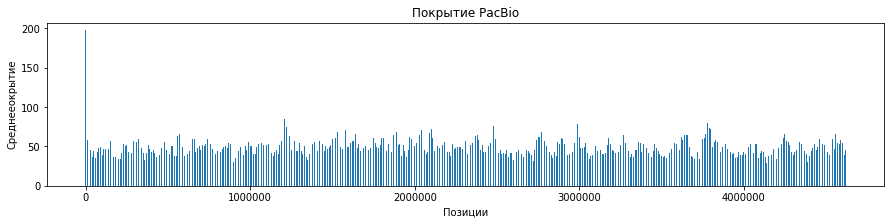

In [11]:
step = 10000

x_axis = [i * step for i in range(0, int(n / step))]
y = [np.mean(coverage[i : i + step]) for i in x_axis]

# я не могу подобрать дурацкие width
plt.figure(figsize=(15, 3))
plt.bar(x_axis, y, width=[5000] * len(y))
plt.xlabel('Позиции')
plt.ylabel('Среднееокрытие')
plt.title('Покрытие PacBio')

In [12]:
# Oxford Nanopores
coverage = SAM_coverage('reference.fasta', 'on.sam')
n = len(coverage)
avg_coverage = coverage.mean()
reference_coverage = np.where(coverage > 0)[0].shape[0] / n * 100
print(f'mean coverage = {avg_coverage:.2f}')
print(f'position coverage = {reference_coverage:.2f}')

mean coverage = 29.08
position coverage = 100.00


Text(0.5, 1.0, 'Покрытие ON')

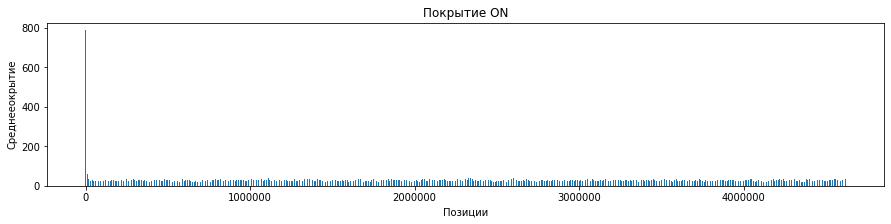

In [13]:
step = 10000

x_axis = [i * step for i in range(0, int(n / step))]
y = [np.mean(coverage[i : i + step]) for i in x_axis]

# я не могу подобрать дурацкие width
plt.figure(figsize=(15, 3))
plt.bar(x_axis, y, width=[5000] * len(y))
plt.xlabel('Позиции')
plt.ylabel('Среднееокрытие')
plt.title('Покрытие ON')

In [18]:
def substitution_matrix(fasta, sam, poly=3):
    letters = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4, '*': 5}
    unique_ref = set()
    unique_sam = set()
    
    with open(fasta) as file:
        reference = ''.join([line.strip() for line in file if not line.startswith('>')])
    ref_length = len(reference)
    
    hp = set()
    state = []
    for pos, ref_position in enumerate(reference):
        if not state or ref_position == state[-1]:
            state.append(ref_position)
            continue
        len_state = len(state)
        if len_state >= poly:
            for i in range(0, len_state - poly + 1):
                hp.add(pos - len_state + i)
        state = []
        state.append(ref_position)
    
    sm = np.zeros([6, 6])
    reads_length, errors = 0, 0
    
    with open(sam) as file:
        cigars = Counter()
        insertions = Counter()
        deletions = Counter()
        
        qinsertions = Counter()
        qdeletions = Counter()
        stats = Counter()
        sum_cnt = Counter()
        
        sum_quality = Counter()
        for i, line in enumerate(file):
            if line.startswith('@'):
                continue
                
            data = line.strip().split()
            start = int(data[3])
            if not start:
                continue
            read_length = len(data[9])
            read = list(data[9])
            
            end = min(start + read_length - 1, ref_length - 1)
            reads_length += read_length
            reference_region = reference[start - 1 : end]
            
            if data[5] and data[5] != '*':
                cigar = list(Cigar(data[5]).items())
                cigar_str = ''.join([c * cnt for (cnt, c) in cigar])
                for (cnt, c) in cigar:
                    cigars[c] += cnt
                    if c == 'I':
                        insertions[cnt] += 1
                    elif c == 'D':
                        deletions[cnt] += 1
                        
                for k, c in enumerate(cigar_str):
                    if c in ('D', 'H'):
                        if c == 'D':
                            if start + k <= ref_length:
                                qdeletions[reference[start + k - 1]] += 1
                    elif c == 'I':
                        try:
                            qinsertions[read[k]] += 1
                        except:
                            pass
                
                        
                cigar_str = ''.join([c * cnt for (cnt, c) in cigar if c not in ('D', 'H')])
                quality = [ord(c) - 33 for c in data[10]]
                for k, c in enumerate(cigar_str):
                    if k >= len(quality):
                        continue
                    sum_cnt[c] += 1
                    sum_quality[c] += quality[k]
                        
            for j, ref_position in enumerate(reference_region):

                if ref_position != read[j]:
                    sm[letters[read[j]], letters[ref_position]] += 1
                    errors += 1    
                if data[2] == '*' or data[5] == '*':
                    continue
                if j in hp:
                    cigar_set = set(cigar_str[j : j + poly])
                    for s in cigar_set:
                        if s == 'M':
                            if len(cigar_set) == 1:
                                stats[s] += 1
                        else:
                            stats[s] += 1
     
    average_quality = {}
    for i in cigars.keys():
        average_quality[i] = 0 if not sum_cnt[i] else sum_quality[i] / sum_cnt[i]
                
    return sm, cigars, errors, reads_length, sorted(list(insertions.items())), sorted(list(deletions.items())), \
hp, stats, average_quality, qdeletions, qinsertions

In [19]:
sm, cigar, errors, reads_length, insertions, deletions, hp, stats, average_quality, qdeletions, \
qinsertons = substitution_matrix(
    'reference.fasta', 'pacbio.sam')

In [20]:
# распределение замен
letters = ['A', 'C', 'G', 'T', 'N', '*']
sm = pd.DataFrame(sm, index=letters, columns=letters)
sm

,A,C,G,T,N,*
A,0.0,14039619.0,13966046.0,13855485.0,0.0,0.0
C,13892282.0,0.0,14348080.0,13843662.0,0.0,0.0
G,13855952.0,14352337.0,0.0,13854375.0,0.0,0.0
T,13846703.0,13998339.0,13968197.0,0.0,0.0,0.0
N,0.0,0.0,0.0,0.0,0.0,0.0
*,365.0,367.0,542.0,462.0,0.0,0.0


In [42]:
pr_errors = (sum(cigar.values()) - cigar['M']) / sum(cigar.values())
print(f'Процент ошибок {pr_errors * 100 :.3f}%')

Процент ошибок 39.066%


Text(0, 0.5, 'Частота, log')

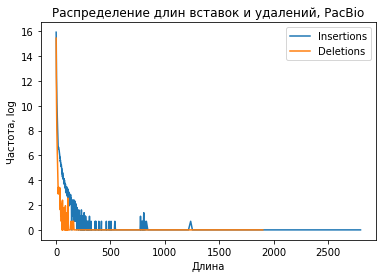

In [23]:
# раньше было лучше...
insertions = pd.DataFrame(insertions, columns=['x', 'y'])
deletions = pd.DataFrame(deletions, columns=['x', 'y'])
# plt.scatter(insertions.x, np.log(insertions.y))
plt.plot(insertions.x, np.log(insertions.y), label='Insertions')

# plt.scatter(deletions.x, np.log(deletions.y))
plt.plot(deletions.x, np.log(deletions.y), label='Deletions')

plt.legend()
plt.title('Распределение длин вставок и удалений, PacBio')
plt.xlabel('Длина')
plt.ylabel('Частота, log')

In [24]:
print('Average quality')
for letter in average_quality:
    print(f'\t{letter}: {average_quality[letter]:.3f}%')
    
# вставки
print('Freq of insertions')
for letter in qinsertons:
    print(f'\t{letter}: {qinsertons[letter] / sum(qinsertons.values()) * 100:.3f}%')
    
# удаления
print('Freq of deletions')
for letter in qdeletions:
    print(f'\t{letter}: {qdeletions[letter] / sum(qdeletions.values()) * 100:.3f}%')

Average quality
	S: 8.599%
	M: 10.102%
	I: 6.782%
	D: 0.000%
	H: 0.000%
Freq of insertions
	C: 24.937%
	T: 25.031%
	A: 25.127%
	G: 24.905%
Freq of deletions
	A: 24.728%
	T: 24.661%
	G: 25.294%
	C: 25.317%


In [25]:
sm, cigar, errors, reads_length, insertions, deletions, hp, stats, average_quality, qdeletions, \
qinsertons = substitution_matrix(
    'reference.fasta', 'on.sam')

In [26]:
# распределение замен
letters = sorted(['A', 'C', 'G', 'T', 'N', '*'])
sm = pd.DataFrame(sm, index=letters, columns=letters)
sm

,*,A,C,G,N,T
*,0.0,7822084.0,7794303.0,7643673.0,0.0,0.0
A,7826354.0,0.0,8223934.0,7813521.0,0.0,0.0
C,7803531.0,8227569.0,0.0,7807681.0,0.0,0.0
G,7644615.0,7803051.0,7804903.0,0.0,0.0,0.0
N,0.0,0.0,0.0,0.0,0.0,0.0
T,268.0,227.0,306.0,262.0,0.0,0.0


In [46]:
pr_errors = (sum(cigar.values()) - cigar['M']) / sum(cigar.values())
print(f'Процент ошибок {pr_errors * 100 :.3f}%')

Процент ошибок 8.593%


Text(0, 0.5, 'Частота, log')

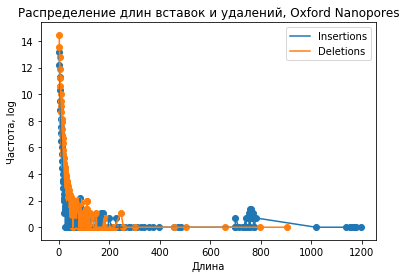

In [27]:
insertions = pd.DataFrame(insertions, columns=['x', 'y'])
deletions = pd.DataFrame(deletions, columns=['x', 'y'])
plt.scatter(insertions.x, np.log(insertions.y))
plt.plot(insertions.x, np.log(insertions.y), label='Insertions')

plt.scatter(deletions.x, np.log(deletions.y))
plt.plot(deletions.x, np.log(deletions.y), label='Deletions')

plt.legend()
plt.title('Распределение длин вставок и удалений, Oxford Nanopores')
plt.xlabel('Длина')
plt.ylabel('Частота, log')

In [28]:
print('Average quality')
for letter in average_quality:
    print(f'\t{letter}: {average_quality[letter]:.3f}%')
    
# вставки
print('Freq of insertions')
for letter in qinsertons:
    print(f'\t{letter}: {qinsertons[letter] / sum(qinsertons.values()) * 100:.3f}%')
    
# удаления
print('Freq of deletions')
for letter in qdeletions:
    print(f'\t{letter}: {qdeletions[letter] / sum(qdeletions.values()) * 100:.3f}%')

Average quality
	S: 12.486%
	M: 22.242%
	D: 0.000%
	I: 11.086%
	H: 0.000%
Freq of insertions
	T: 24.462%
	G: 25.595%
	C: 25.462%
	A: 24.481%
Freq of deletions
	A: 24.566%
	C: 25.459%
	T: 24.531%
	G: 25.444%


In [ ]:
# если сравнивать с предыдущими ДЗ, то ошибок значительно больше получается (я не уверена, что моя прога 
# правильно посчитала % ощибок у PacBio, вроде так не должно быть)